In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

sns.set_theme()

# import utils
import sys
sys.path.append('../../../utils')
import calibrate, simulate, misc, rv_estimators

In [2]:
df = pd.read_csv("../../../../datasets/TrueFX/EURUSD-2024-02/EURUSD-2024-02.csv", header=None)
df.columns = ['Pair', 'TimeStamp', 'Bid', 'Ask']
df['Timestamp'] = pd.to_datetime(df['TimeStamp']) - pd.Timedelta(hours=5) # turn GMT to EST time
df = df[['Timestamp', 'Bid', 'Ask']]

df['Date'] = df['Timestamp'].dt.date
df['Time'] = df['Timestamp'].dt.time
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second

df['Mid'] = (df['Bid'] + df['Ask']) / 2

In [18]:
oneday

,Timestamp,Bid,Ask,Date,Time,Hour,Minute,Second,Mid
1567300,2024-02-04 17:05:57.197,1.07840,1.07850,2024-02-04,17:05:57.197000,17,5,57,1.078450
1567301,2024-02-04 17:06:00.213,1.07841,1.07851,2024-02-04,17:06:00.213000,17,6,0,1.078460
1567302,2024-02-04 17:06:04.713,1.07841,1.07850,2024-02-04,17:06:04.713000,17,6,4,1.078455
1567303,2024-02-04 17:06:10.057,1.07840,1.07849,2024-02-04,17:06:10.057000,17,6,10,1.078445
1567304,2024-02-04 17:06:14.697,1.07840,1.07850,2024-02-04,17:06:14.697000,17,6,14,1.078450
...,...,...,...,...,...,...,...,...,...
2345684,2024-02-05 23:59:58.580,1.07488,1.07492,2024-02-05,23:59:58.580000,23,59,58,1.074900
2345685,2024-02-05 23:59:58.580,1.07486,1.07493,2024-02-05,23:59:58.580000,23,59,58,1.074895
2345686,2024-02-05 23:59:59.049,1.07489,1.07492,2024-02-05,23:59:59.049000,23,59,59,1.074905
2345687,2024-02-05 23:59:59.627,1.07485,1.07493,2024-02-05,23:59:59.627000,23,59,59,1.074890


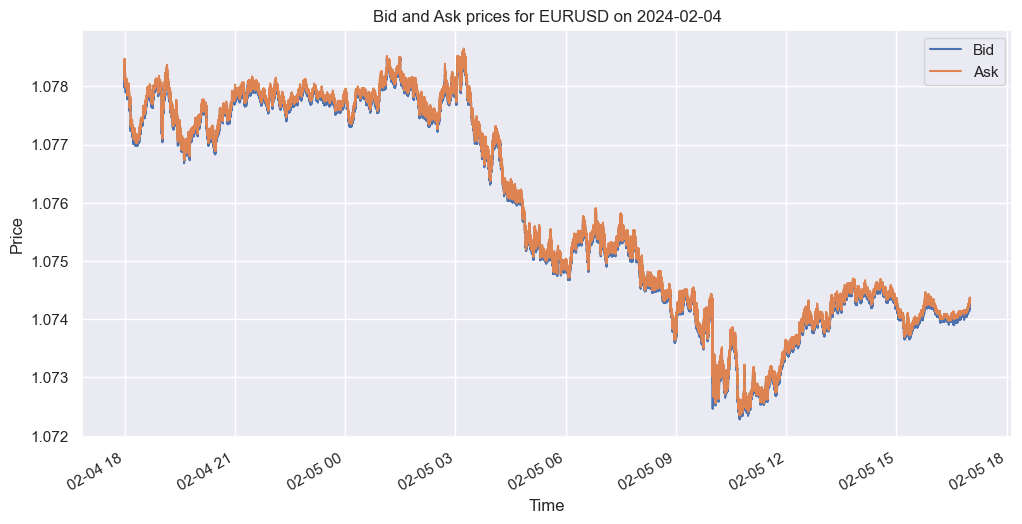

In [27]:
chosen_date = pd.to_datetime('2024-02-04').date()
t_start = pd.to_datetime('2024-02-04 18h')
t_end = pd.to_datetime('2024-02-05 17h')
oneday = df[(df['Timestamp']>=t_start) & (df['Timestamp']<=t_end) ]
oneday.plot(x='Timestamp', y=['Bid', 'Ask'], xlabel="Time", ylabel="Price", title="Bid and Ask prices for EURUSD on {}".format(chosen_date), figsize=(12, 6))
plt.show()

In [53]:
S = oneday['Bid']
X = np.log(S)
ts = pd.Series(data=X.values, index=oneday['Timestamp'])

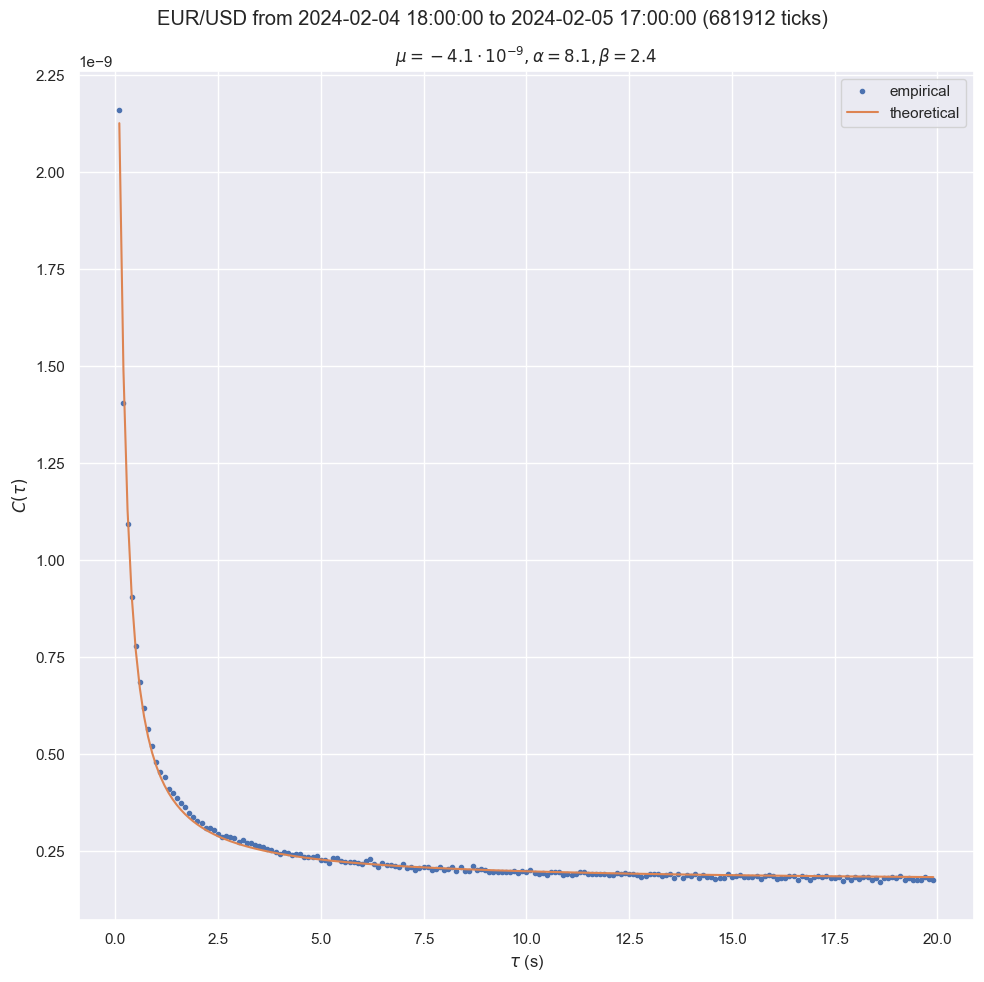

In [72]:
hours = oneday['Hour'].unique()
taus = misc.range_timedelta(100, 20000, 100, 'ms')

n_points = len(ts)
C_emp_values = [misc.C_emp(ts, tau) for tau in taus]
theta_hat = misc.curve_calibrate(taus, C_emp_values)
C_th_func = misc.C_th(theta_hat)
C_th_values = [C_th_func(tau.total_seconds()) for tau in taus]

plt.figure(figsize=(10,10))
plt.plot(taus.dt.total_seconds(), C_emp_values, label='empirical', ls='', marker='.')
plt.plot(taus.dt.total_seconds(), C_th_values, label='theoretical')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$C(\tau)$')
plt.legend()
plt.tight_layout()
plt.suptitle(f'EUR/USD from {t_start} to {t_end} ({n_points} ticks)')
plt.title(r'$\mu={:.1f}\cdot10^{}, \alpha={:.1f}, \beta={:.1f}$'.format(1e9*theta_hat[0], '{-9}', theta_hat[1], theta_hat[2]))
plt.tight_layout()
plt.show()

In [93]:
iv_naive, iv_best_10, iv_best_100, iv_best_1000, iv_best_10000 = [], [], [], [], []
for tau in tqdm(taus):
    iv_naive_est = rv_estimators.rv_naive(ts=ts,tau=tau,verbose=False)
    iv_best_est_10 = rv_estimators.rv_best(ts=ts,tau=tau,K=10,verbose=False)
    iv_best_est_100 = rv_estimators.rv_best(ts=ts,tau=tau,K=100,verbose=False)
    iv_best_est_1000 = rv_estimators.rv_best(ts=ts,tau=tau,K=1000,verbose=False)
    iv_best_est_10000 = rv_estimators.rv_best(ts=ts,tau=tau,K=10000,verbose=False)
    iv_naive.append(iv_naive_est)
    iv_best_10.append(iv_best_est_10)
    iv_best_100.append(iv_best_est_100)
    iv_best_1000.append(iv_best_est_1000)
    iv_best_10000.append(iv_best_est_10000)

 27%|██▋       | 53/199 [09:37<29:15, 12.03s/it]

In [92]:
681912/(23*60*60)

8.235652173913044

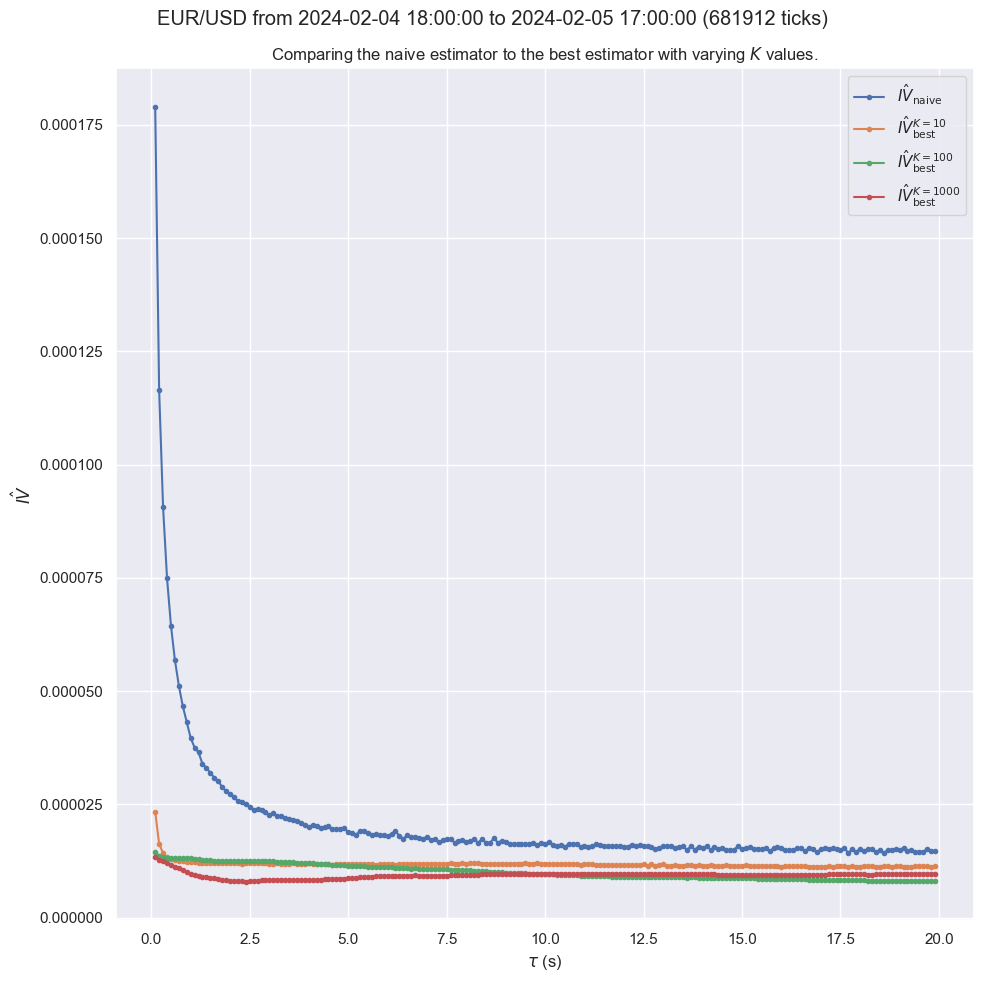

In [90]:
plt.figure(figsize=(10,10))
plt.plot(taus.dt.total_seconds(), iv_naive, label=r'$\hat{IV}_\text{naive}$', marker='.')
plt.plot(taus.dt.total_seconds(), iv_best_10, label=r'$\hat{IV}_\text{best}^{K=10}$', marker='.')
plt.plot(taus.dt.total_seconds(), iv_best_100, label=r'$\hat{IV}_\text{best}^{K=100}$', marker='.')
plt.plot(taus.dt.total_seconds(), iv_best_1000, label=r'$\hat{IV}_\text{best}^{K=1000}$', marker='.')
plt.plot(taus.dt.total_seconds(), iv_best_10000, label=r'$\hat{IV}_\text{best}^{K=10000}$', marker='.')
plt.xlabel(r'$\tau$ (s)')
plt.ylabel(r'$\hat{IV}$')
plt.legend()
plt.tight_layout()
plt.suptitle(f'EUR/USD from {t_start} to {t_end} ({n_points} ticks)')
plt.title('Comparing the naive estimator to the best estimator with varying $K$ values.')
plt.tight_layout()
plt.show()